In [1]:
import pandas as pd

# Load the dataframe.
df = pd.read_csv("fraud_oracle.csv")

# Print some info.
print(df.head())
print(df.info())

  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0          26 to 30 

Veri Setinin İlk 5 Satırı:
  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentT

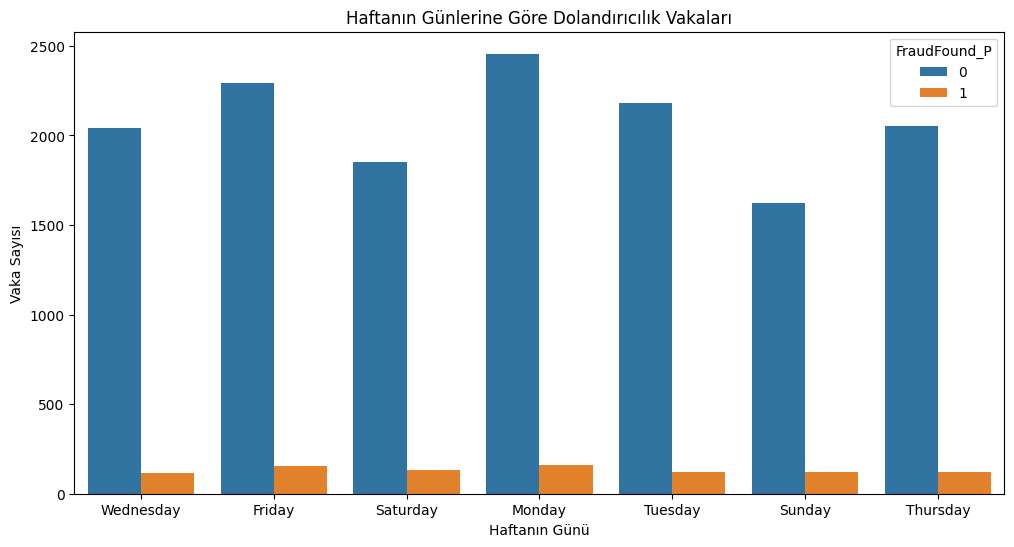

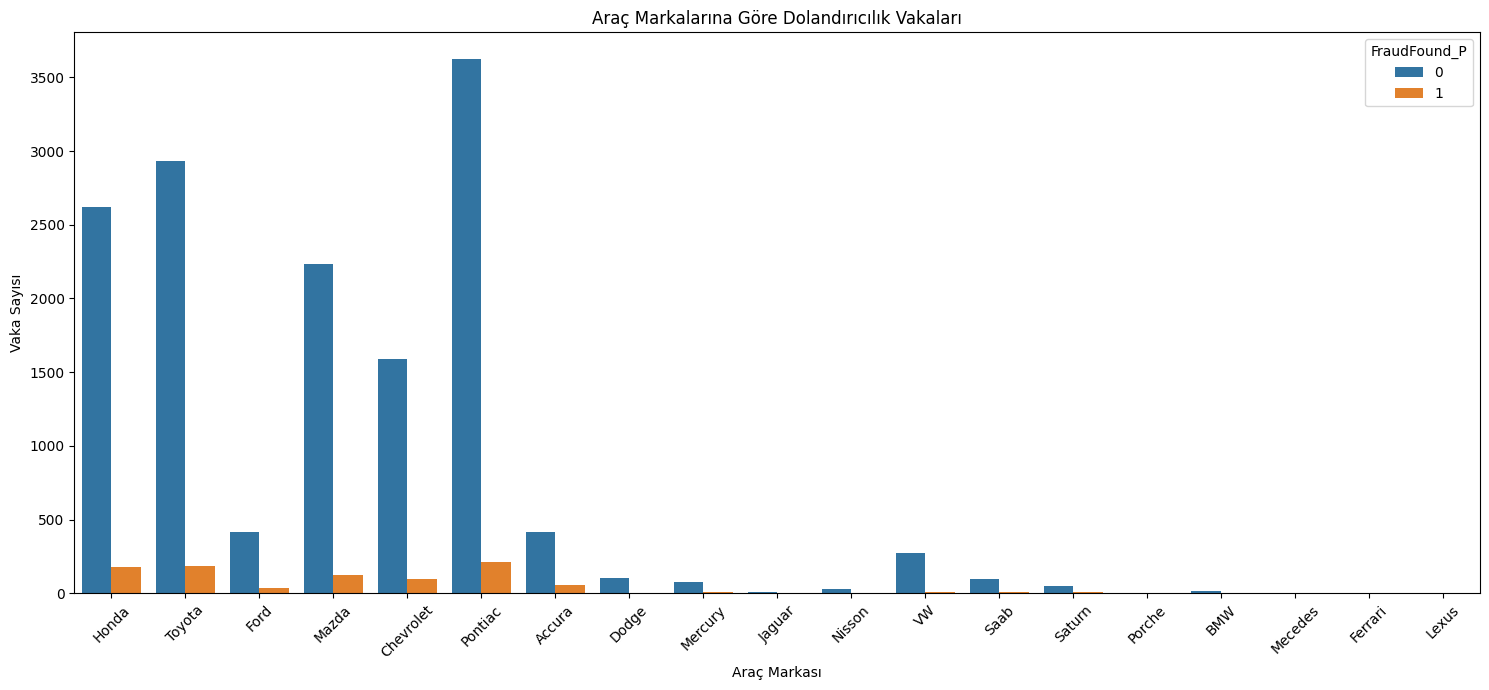


Eğitim Seti Boyutu: 10794 satır, 88 sütun
Test Seti Boyutu: 4626 satır, 88 sütun

Model Eğitimi Başlıyor...
Model Eğitimi Tamamlandı.

Karışıklık Matrisi:
[[4348    1]
 [ 274    3]]


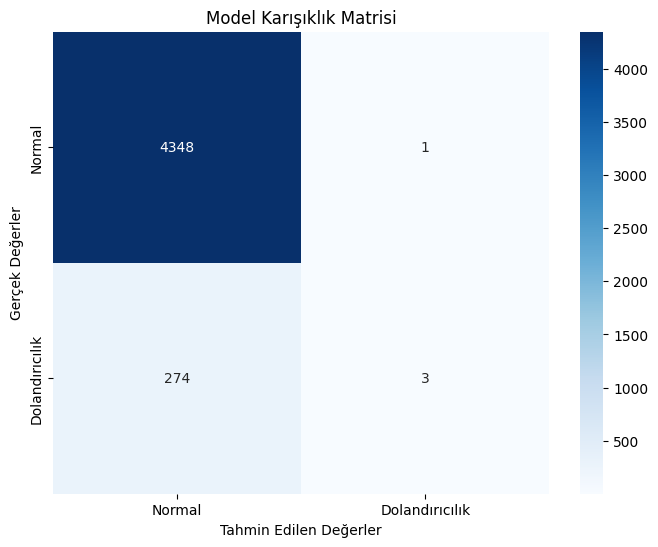


Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.75      0.01      0.02       277

    accuracy                           0.94      4626
   macro avg       0.85      0.51      0.50      4626
weighted avg       0.93      0.94      0.91      4626



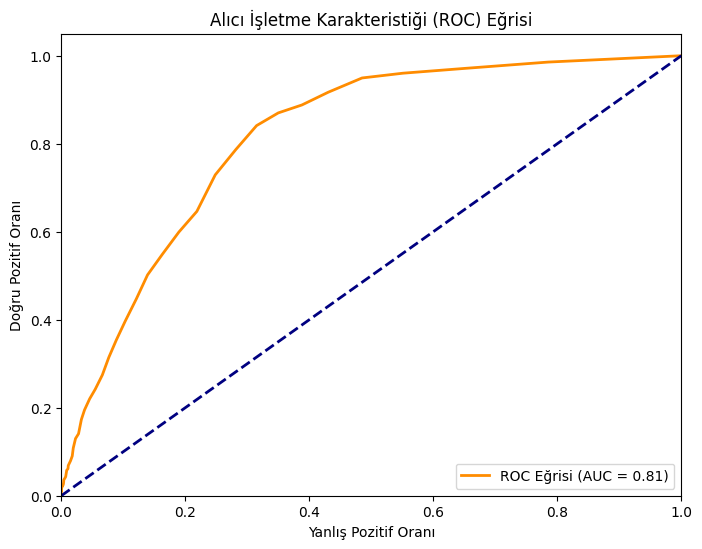


En Önemli Özellikler:
                     importance
Age                    0.085958
WeekOfMonth            0.046591
WeekOfMonthClaimed     0.045835
AgeOfVehicle           0.039753
AgeOfPolicyHolder      0.039243
PastNumberOfClaims     0.036742
Year                   0.036234
NumberOfSuppliments    0.035587
VehiclePrice           0.031658
Fault_Third Party      0.031621


In [2]:
# Gerekli kütüphaneleri içe aktarma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# --- 1. Veri Yükleme ve Ön İnceleme ---
# Veri setini yükleme
df = pd.read_csv("fraud_oracle.csv")

# Veri setinin ilk birkaç satırını ve genel bilgilerini gösterme
print("Veri Setinin İlk 5 Satırı:")
print(df.head())
print("\nVeri Seti Bilgileri:")
df.info()

# Hedef değişkenin (dolandırıcılık vakaları) dağılımını inceleme
# Bu dağılım, sınıf dengesizliğinin olup olmadığını gösterir.
print("\nDolandırıcılık Vakası Dağılımı:")
print(df['FraudFound_P'].value_counts(normalize=True) * 100)

# --- 2. Keşifsel Veri Analizi (EDA) ---
# Dolandırıcılık vakalarının haftanın günlerine göre dağılımını görselleştirme
plt.figure(figsize=(12, 6))
sns.countplot(x='DayOfWeek', hue='FraudFound_P', data=df)
plt.title('Haftanın Günlerine Göre Dolandırıcılık Vakaları')
plt.xlabel('Haftanın Günü')
plt.ylabel('Vaka Sayısı')
plt.savefig('fraud_by_dayofweek.png')
plt.show()

# Dolandırıcılık vakalarının araç markalarına göre dağılımını görselleştirme
plt.figure(figsize=(15, 7))
sns.countplot(x='Make', hue='FraudFound_P', data=df)
plt.title('Araç Markalarına Göre Dolandırıcılık Vakaları')
plt.xlabel('Araç Markası')
plt.ylabel('Vaka Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fraud_by_make.png')
plt.show()

# --- 3. Veri Ön İşleme ve Özellik Mühendisliği ---
# Model için gereksiz sütunları kaldırma
df = df.drop(columns=['PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating'])

# Kategorik verileri sayısal hale getirme
# Ordinal (sıralı) kategorik verileri Label Encoding ile dönüştürme
# Bu sütunlar için özel bir sıralama belirlemek daha doğru olabilir.
for col in ['Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'VehiclePrice']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Nominal kategorik verileri One-Hot Encoding ile dönüştürme
# Bu, modelin kategorik değişkenleri doğru anlamasını sağlar.
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Veriyi özellikler (X) ve hedef değişken (y) olarak ayırma
X = df.drop(columns='FraudFound_P')
y = df['FraudFound_P']

# Veriyi eğitim ve test setlerine ayırma
# Stratify parametresi, hedef değişkenin dağılımını eğitim ve test setlerinde korur.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nEğitim Seti Boyutu: {X_train.shape[0]} satır, {X_train.shape[1]} sütun")
print(f"Test Seti Boyutu: {X_test.shape[0]} satır, {X_test.shape[1]} sütun")

# --- 4. Model Oluşturma ve Eğitim ---
# RandomForestClassifier modelini oluşturma ve eğitme
# Sınıf dengesizliği için 'class_weight="balanced"' parametresi kullanılabilir.
model = RandomForestClassifier(n_estimators=100, random_state=42)

print("\nModel Eğitimi Başlıyor...")
model.fit(X_train, y_train)
print("Model Eğitimi Tamamlandı.")

# --- 5. Model Değerlendirme ---
# Test seti üzerinde tahmin yapma
y_pred = model.predict(X_test)

# Karışıklık matrisini (Confusion Matrix) hesaplama ve görselleştirme
cm = confusion_matrix(y_test, y_pred)
print("\nKarışıklık Matrisi:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Dolandırıcılık'], yticklabels=['Normal', 'Dolandırıcılık'])
plt.title('Model Karışıklık Matrisi')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.savefig('confusion_matrix.png')
plt.show()

# Sınıflandırma raporunu (Classification Report) yazdırma
# Bu rapor, kesinlik, duyarlılık ve F1-Skor gibi kritik metrikleri içerir.
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# ROC eğrisini çizme
# Modelin farklı eşik değerlerindeki performansını gösterir.
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Alıcı İşletme Karakteristiği (ROC) Eğrisi')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

# Özellik önemini (Feature Importance) analiz etme
# Hangi özelliklerin model tahminlerinde en etkili olduğunu gösterir.
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("\nEn Önemli Özellikler:")
print(feature_importances.head(10))

Bu projede, 15.420 sigorta hasar kaydı kullanılarak olası dolandırıcılık vakalarının tespiti amaçlanmıştır. Veri setindeki dengesiz sınıf yapısına rağmen, Random Forest modeli ile %94 doğruluk elde edilmiştir. Özellik önem analizinde sigortalının yaşı, kaza ve talebin haftası, araç yaşı ve geçmiş talep sayısı en etkili değişkenler olarak öne çıkmıştır. Gelecek çalışmalarda sınıf dengesizliği giderilerek dolandırıcılık yakalama oranının artırılması hedeflenmektedir.